In [112]:
!pip install catboost

In [113]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import catboost

from matplotlib import pyplot as plt
# %matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [114]:
!wget https://raw.githubusercontent.com/prometneus/Nonribosomal-Peptides/main/data/FullDB.csv

--2021-07-09 12:39:51--  https://raw.githubusercontent.com/prometneus/Nonribosomal-Peptides/main/data/FullDB.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 612651 (598K) [text/plain]
Saving to: ‘FullDB.csv.1’

FullDB.csv.1        100%[===================>] 598.29K  --.-KB/s    in 0.01s   

2021-07-09 12:39:51 (40.7 MB/s) - ‘FullDB.csv.1’ saved [612651/612651]



In [115]:
data = pd.read_csv("FullDB.csv")
data.head(10)

,spec,Sequence,8A-signature,stachelhaus-code
0,pro,YRELDERANRLAHLLAAHGVGPERIVALALPRSVDLVVAVLAVLKA...,LWHTFDVSAQESFAAQAGEHNHYGPTETHVVTAH,DVQFAAHVV-
1,pro,TYKELNESANRLARHLRKKGVMRQEPVAIMMERSTEFVTGILGILK...,LFEAFDVCYQESVSITAGEHNHYGPSETHVVSAY,DVQVIAHVV-
2,pro,TYRELHERSNQLARFLREKGVKKESIIGIMMERSVEMIVGILGILK...,LFTTFDVCYQESSFITAGEHNHYGPSETHVVTTY,DVQSIAHVV-
3,pro,SYRRLDQLSSSLAEELIGHGVGVEMTIPVLLEKTCWTPVAMLAVLK...,AHLSWDIPVTDLLLVLAGEIQGYGPAECSLVSTV,DITLVAGLV-
4,pro,TYRELNKAANRLARHLRMKGVVRQEPVAIMMERSAAFITGVLGILK...,LFEAFDVCYQESFLIAAGEHNHYGPSETHVVSTY,DVQFIAHVV-
5,pro,TYRELWAHSSFFARQLQRYGVTRGTPVAVCLDRSRWSIAVILGVLL...,SHHSFDVSIYETFLVLGGEINGYGPAEATICGVG,DVYFVGGIC-
6,pro,TYQQLNQKANQLAHSLQCLGVTPDSLVAICLERSLDMAVAILGTLK...,LHHAFDVSYHEAILITAGEYNFYGPSEADLVTAY,DVHIIAFLV-
7,pro,SYTELERVSSTWARQLQKQGISQGSWVLFCFEKSRLAVVSMIAILK...,AAYSFDISIADTVLIFTGEYNVYGPAENTLITTA,DIAVITVLI-
8,pro,TYSELDRQSDELAGWLRQQRLPAESLVAVLAPRSCQTIVAFLGILK...,VSPTFDVSLWETVFFSSGDHNAYGPTENGIQSTI,DVWVFSAIQ-
9,pro,TYYELNYRANQLAHYLQSLGVGSDALVGLCVERSLEMVIGLLGILK...,LWHAFDVSFQETFLITAGEHNHYGPSESHLATSF,DVQFIAHLA-


In [116]:
data.dropna()
data.isna().sum()

spec                0
Sequence            0
8A-signature        0
stachelhaus-code    0
dtype: int64

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   spec              1354 non-null   object
 1   Sequence          1354 non-null   object
 2   8A-signature      1354 non-null   object
 3   stachelhaus-code  1354 non-null   object
dtypes: object(4)
memory usage: 42.4+ KB


In [118]:
# refuse = ['dht', 'dab', 'pip', 'trp', 'ala-b', 'abu', 'ser-thr', 'sal', 'lys-b',
#           'alaninol', 'vol', 'd-lyserg', 'tcl', '3-me-glu', 'dpg', '4ppro',
#           'bmt', 'ala-d', 'aeo', 'hiv', 'his', 'phg', 'spec', 'pip']
# for i, elem in enumerate(refuse):
#   data.drop(data[data['spec'] == refuse[i]].index, inplace=True)

# data.head(10)

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354 entries, 0 to 1353
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   spec              1354 non-null   object
 1   Sequence          1354 non-null   object
 2   8A-signature      1354 non-null   object
 3   stachelhaus-code  1354 non-null   object
dtypes: object(4)
memory usage: 42.4+ KB


In [120]:
# for ctg in data:
#   plot,figure = plt.subplots() 
#   colors = ['red', 'lightskyblue', 'yellowgreen', 'lightcoral']
#   lbl = list(data[ctg].value_counts().index)
#   figure.pie(data[ctg].value_counts(normalize=True).tolist(),
#              colors = colors, labels=lbl,autopct='%1.2f%%')
#   figure.axis('equal') 
#   figure.set_title(ctg)
#   plt.show()

In [121]:
X = data['8A-signature']
y = data['spec']
X.head(10)

0    LWHTFDVSAQESFAAQAGEHNHYGPTETHVVTAH
1    LFEAFDVCYQESVSITAGEHNHYGPSETHVVSAY
2    LFTTFDVCYQESSFITAGEHNHYGPSETHVVTTY
3    AHLSWDIPVTDLLLVLAGEIQGYGPAECSLVSTV
4    LFEAFDVCYQESFLIAAGEHNHYGPSETHVVSTY
5    SHHSFDVSIYETFLVLGGEINGYGPAEATICGVG
6    LHHAFDVSYHEAILITAGEYNFYGPSEADLVTAY
7    AAYSFDISIADTVLIFTGEYNVYGPAENTLITTA
8    VSPTFDVSLWETVFFSSGDHNAYGPTENGIQSTI
9    LWHAFDVSFQETFLITAGEHNHYGPSESHLATSF
Name: 8A-signature, dtype: object

In [122]:
print(pd.unique(y))
print(len(pd.unique(y)))

['pro' 'phe' 'asn' 'gln' 'tyr' 'val' 'orn' 'leu' 'ile' 'cys' 'glu' 'lys'
 'asp' 'thr' 'trp' 'gly' 'ala' 'ser' 'dhb' 'aad' 'pip' 'bht' 'hpg' 'dhpg'
 'beta-ala' 'dab' 'arg' 'horn' 'hyv-d' 'dht']
30


In [123]:
uarr = []
for line in X:
  uarr += set(line)
uarr = set(uarr)
uarr

{'-',
 'A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y'}

In [124]:
uarr_dum = pd.get_dummies(list(uarr))
uarr_dum['Y']

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
Name: Y, dtype: uint8

In [125]:
result = []
for line in X:
  new_line = []
  for char in line:
    new_line.append(uarr_dum[char])
  result.append(new_line)

In [126]:
np.array(result).shape

(1354, 34, 21)

In [127]:
_X_ = np.array(result)

In [128]:
labels = ['spec']
y = np.array(y)
y.tolist()

['pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'pro',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'phe',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',
 'asn',


In [129]:
_X_.shape, y.shape

((1354, 34, 21), (1354,))

In [130]:
X_train, X_test, y_train, y_test = train_test_split(_X_, y, train_size = 0.8)

In [131]:
X_train.shape, y_train.shape

((1083, 34, 21), (1083,))

In [132]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test =  X_test.reshape(X_test.shape[0],-1)

In [133]:
labels = sorted(set(data['spec'].unique()))

# Naive Bayes

Cross Validation accuracy scores: [0.8440367  0.81651376 0.82568807 0.86111111 0.82407407 0.83333333
 0.82407407 0.87962963 0.80555556 0.74074074]
Cross Validation accuracy: 0.825 +/- 0.035
Naive Bayes accuracy: 0.871
Naive Bayes macro f1-score: 0.691
              precision    recall  f1-score   support

         aad       0.90      1.00      0.95         9
         ala       0.97      0.99      0.98       115
         asn       0.50      0.33      0.40         3
         asp       1.00      0.80      0.89         5
    beta-ala       0.00      0.00      0.00         1
         bht       1.00      1.00      1.00         1
         cys       1.00      0.89      0.94         9
         dab       1.00      0.50      0.67         2
         dhb       1.00      0.93      0.97        46
         dht       0.33      1.00      0.50         1
         gln       1.00      1.00      1.00         1
         glu       0.75      0.60      0.67         5
         gly       1.00      0.67      0.80  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


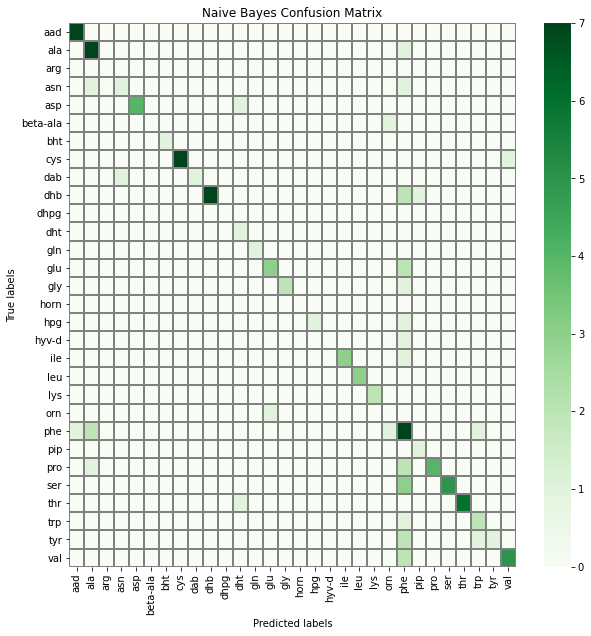

In [179]:
# Create a Gaussian classifier
nb_model = GaussianNB()

kf = KFold(n_splits=10)
results = cross_val_score(nb_model, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),
                                                    np.std(results)))
print('===================')

nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)

print('Naive Bayes accuracy:', round(accuracy_score(y_test, nb_pred), 3))
print('Naive Bayes macro f1-score:', round(f1_score(y_test, nb_pred, average='macro'), 3))
print(classification_report(y_test, nb_model.predict(X_test)))

cm_nb = confusion_matrix(y_test, nb_pred, labels=labels)

k = 7
cm_nb[cm_nb > k] = k

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_nb, ax=ax, fmt='g', cmap='Greens', 
            xticklabels=labels, yticklabels=labels, 
            linewidth=1, linecolor='grey') 

# labels, title and ticks
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels') 
_ = ax.set_title('Naive Bayes Confusion Matrix') 

# Catboost

In [172]:
# cat = CatBoostClassifier()
# params = {  
#     "max_depth": [7],
#     "learning_rate": [0.4],
#     "iterations": [75]
# }

# search_cat = GridSearchCV(estimator=cat, param_grid = params, n_jobs=-1)
# kf = KFold(n_splits=10)
# results = cross_val_score(search_cat, X_train, y_train, cv=kf)
# print('Cross Validation accuracy scores: %s' % results)
# print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),
#                                                     np.std(results)))
# print('===================')

# search_cat.fit(X_train, y_train)
# search_cat.best_params_

# print(classification_report(y_test, search_cat.best_estimator_.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 1.4628232	total: 58.5ms	remaining: 4.33s
1:	learn: 1.3445801	total: 114ms	remaining: 4.15s
2:	learn: 1.1772666	total: 168ms	remaining: 4.04s
3:	learn: 1.0475406	total: 223ms	remaining: 3.96s
4:	learn: 0.9906166	total: 282ms	remaining: 3.94s
5:	learn: 0.9243912	total: 336ms	remaining: 3.87s
6:	learn: 0.8847219	total: 393ms	remaining: 3.82s
7:	learn: 0.8434080	total: 449ms	remaining: 3.76s
8:	learn: 0.8003268	total: 506ms	remaining: 3.71s
9:	learn: 0.7547677	total: 561ms	remaining: 3.64s
10:	learn: 0.7367262	total: 630ms	remaining: 3.67s
11:	learn: 0.7209040	total: 688ms	remaining: 3.61s
12:	learn: 0.7111060	total: 748ms	remaining: 3.57s
13:	learn: 0.6785400	total: 803ms	remaining: 3.5s
14:	learn: 0.6517572	total: 859ms	remaining: 3.43s
15:	learn: 0.6271869	total: 914ms	remaining: 3.37s
16:	learn: 0.5968295	total: 972ms	remaining: 3.31s
17:	learn: 0.5724288	total: 1.03s	remaining: 3.25s
18:	learn: 0.5640166	total: 1.08s	remaining: 3.2s
19:	learn: 0.5440052	total: 1.14s	remainin

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 1.4614112	total: 54.2ms	remaining: 4.01s
1:	learn: 1.2249749	total: 107ms	remaining: 3.92s
2:	learn: 1.1156227	total: 160ms	remaining: 3.84s
3:	learn: 1.0150351	total: 215ms	remaining: 3.82s
4:	learn: 0.9288214	total: 274ms	remaining: 3.84s
5:	learn: 0.8846617	total: 329ms	remaining: 3.79s
6:	learn: 0.8529502	total: 383ms	remaining: 3.71s
7:	learn: 0.7927024	total: 444ms	remaining: 3.72s
8:	learn: 0.7462880	total: 505ms	remaining: 3.7s
9:	learn: 0.7254343	total: 562ms	remaining: 3.65s
10:	learn: 0.7064597	total: 617ms	remaining: 3.59s
11:	learn: 0.6763389	total: 671ms	remaining: 3.52s
12:	learn: 0.6578663	total: 729ms	remaining: 3.48s
13:	learn: 0.6412336	total: 784ms	remaining: 3.41s
14:	learn: 0.6203658	total: 842ms	remaining: 3.37s
15:	learn: 0.6000294	total: 898ms	remaining: 3.31s
16:	learn: 0.5721152	total: 956ms	remaining: 3.26s
17:	learn: 0.5494107	total: 1.01s	remaining: 3.2s
18:	learn: 0.5291809	total: 1.07s	remaining: 3.15s
19:	learn: 0.5153082	total: 1.12s	remainin

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 1.4541347	total: 55.9ms	remaining: 4.14s
1:	learn: 1.2811567	total: 110ms	remaining: 4.02s
2:	learn: 1.1588167	total: 163ms	remaining: 3.92s
3:	learn: 1.0744052	total: 217ms	remaining: 3.85s
4:	learn: 0.9684066	total: 277ms	remaining: 3.88s
5:	learn: 0.8942517	total: 332ms	remaining: 3.82s
6:	learn: 0.8300750	total: 386ms	remaining: 3.75s
7:	learn: 0.8163804	total: 439ms	remaining: 3.67s
8:	learn: 0.7705874	total: 496ms	remaining: 3.63s
9:	learn: 0.7434796	total: 552ms	remaining: 3.59s
10:	learn: 0.7045072	total: 607ms	remaining: 3.53s
11:	learn: 0.6607649	total: 661ms	remaining: 3.47s
12:	learn: 0.6331525	total: 718ms	remaining: 3.42s
13:	learn: 0.6156800	total: 774ms	remaining: 3.37s
14:	learn: 0.5981348	total: 831ms	remaining: 3.32s
15:	learn: 0.5888783	total: 890ms	remaining: 3.28s
16:	learn: 0.5675844	total: 947ms	remaining: 3.23s
17:	learn: 0.5527462	total: 1.01s	remaining: 3.2s
18:	learn: 0.5415730	total: 1.06s	remaining: 3.13s
19:	learn: 0.5203627	total: 1.12s	remaini

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 1.5062814	total: 54.3ms	remaining: 4.02s
1:	learn: 1.3300740	total: 109ms	remaining: 3.99s
2:	learn: 1.1621288	total: 170ms	remaining: 4.09s
3:	learn: 1.1274088	total: 225ms	remaining: 3.99s
4:	learn: 1.0586114	total: 284ms	remaining: 3.98s
5:	learn: 0.9841564	total: 339ms	remaining: 3.89s
6:	learn: 0.9152222	total: 393ms	remaining: 3.82s
7:	learn: 0.8609341	total: 447ms	remaining: 3.75s
8:	learn: 0.8015774	total: 504ms	remaining: 3.7s
9:	learn: 0.7600666	total: 561ms	remaining: 3.65s
10:	learn: 0.7334417	total: 622ms	remaining: 3.62s
11:	learn: 0.7136410	total: 679ms	remaining: 3.56s
12:	learn: 0.6915402	total: 738ms	remaining: 3.52s
13:	learn: 0.6709120	total: 793ms	remaining: 3.45s
14:	learn: 0.6533655	total: 815ms	remaining: 3.26s
15:	learn: 0.6302877	total: 870ms	remaining: 3.21s
16:	learn: 0.6170450	total: 927ms	remaining: 3.16s
17:	learn: 0.5941147	total: 988ms	remaining: 3.13s
18:	learn: 0.5801181	total: 1.04s	remaining: 3.07s
19:	learn: 0.5639769	total: 1.1s	remainin

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 1.4901562	total: 56ms	remaining: 4.14s
1:	learn: 1.2248371	total: 110ms	remaining: 4.01s
2:	learn: 1.1092269	total: 165ms	remaining: 3.96s
3:	learn: 1.0034533	total: 221ms	remaining: 3.93s
4:	learn: 0.9363133	total: 280ms	remaining: 3.92s
5:	learn: 0.8789227	total: 336ms	remaining: 3.86s
6:	learn: 0.8017779	total: 390ms	remaining: 3.79s
7:	learn: 0.7549848	total: 443ms	remaining: 3.71s
8:	learn: 0.7136963	total: 500ms	remaining: 3.67s
9:	learn: 0.6786619	total: 560ms	remaining: 3.64s
10:	learn: 0.6435939	total: 615ms	remaining: 3.58s
11:	learn: 0.6195410	total: 671ms	remaining: 3.52s
12:	learn: 0.5975963	total: 731ms	remaining: 3.49s
13:	learn: 0.5847923	total: 787ms	remaining: 3.43s
14:	learn: 0.5662301	total: 843ms	remaining: 3.37s
15:	learn: 0.5522197	total: 902ms	remaining: 3.33s
16:	learn: 0.5365405	total: 967ms	remaining: 3.3s
17:	learn: 0.5172195	total: 1.02s	remaining: 3.24s
18:	learn: 0.5064797	total: 1.08s	remaining: 3.17s
19:	learn: 0.4848787	total: 1.13s	remaining

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 1.4253886	total: 54.6ms	remaining: 4.04s
1:	learn: 1.2536036	total: 110ms	remaining: 4.03s
2:	learn: 1.1325304	total: 164ms	remaining: 3.94s
3:	learn: 1.0421416	total: 221ms	remaining: 3.92s
4:	learn: 0.9693552	total: 281ms	remaining: 3.93s
5:	learn: 0.8777145	total: 336ms	remaining: 3.86s
6:	learn: 0.8049321	total: 390ms	remaining: 3.79s
7:	learn: 0.7816519	total: 453ms	remaining: 3.79s
8:	learn: 0.7442469	total: 511ms	remaining: 3.75s
9:	learn: 0.6982931	total: 571ms	remaining: 3.71s
10:	learn: 0.6569597	total: 627ms	remaining: 3.65s
11:	learn: 0.6382302	total: 684ms	remaining: 3.59s
12:	learn: 0.6060090	total: 745ms	remaining: 3.55s
13:	learn: 0.5983468	total: 799ms	remaining: 3.48s
14:	learn: 0.5757828	total: 856ms	remaining: 3.42s
15:	learn: 0.5570617	total: 913ms	remaining: 3.37s
16:	learn: 0.5348859	total: 974ms	remaining: 3.32s
17:	learn: 0.5191685	total: 1.03s	remaining: 3.26s
18:	learn: 0.5056141	total: 1.08s	remaining: 3.19s
19:	learn: 0.4911363	total: 1.14s	remain

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 1.3798792	total: 55.9ms	remaining: 4.14s
1:	learn: 1.1618773	total: 111ms	remaining: 4.06s
2:	learn: 1.0260956	total: 165ms	remaining: 3.96s
3:	learn: 0.9382581	total: 220ms	remaining: 3.9s
4:	learn: 0.9020007	total: 283ms	remaining: 3.96s
5:	learn: 0.8473997	total: 337ms	remaining: 3.88s
6:	learn: 0.8006742	total: 392ms	remaining: 3.81s
7:	learn: 0.7578412	total: 447ms	remaining: 3.74s
8:	learn: 0.7327585	total: 505ms	remaining: 3.7s
9:	learn: 0.7146791	total: 566ms	remaining: 3.68s
10:	learn: 0.6797815	total: 623ms	remaining: 3.62s
11:	learn: 0.6666298	total: 678ms	remaining: 3.56s
12:	learn: 0.6444877	total: 734ms	remaining: 3.5s
13:	learn: 0.6253562	total: 788ms	remaining: 3.43s
14:	learn: 0.6032992	total: 845ms	remaining: 3.38s
15:	learn: 0.5755575	total: 900ms	remaining: 3.32s
16:	learn: 0.5470243	total: 961ms	remaining: 3.28s
17:	learn: 0.5367878	total: 1.02s	remaining: 3.25s
18:	learn: 0.5208219	total: 1.08s	remaining: 3.19s
19:	learn: 0.5104756	total: 1.14s	remaining

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 1.4162328	total: 55.2ms	remaining: 4.09s
1:	learn: 1.2295149	total: 109ms	remaining: 3.98s
2:	learn: 1.0997560	total: 166ms	remaining: 3.97s
3:	learn: 1.0263949	total: 222ms	remaining: 3.94s
4:	learn: 0.9544547	total: 284ms	remaining: 3.97s
5:	learn: 0.8962141	total: 340ms	remaining: 3.91s
6:	learn: 0.8390051	total: 403ms	remaining: 3.92s
7:	learn: 0.8080338	total: 460ms	remaining: 3.85s
8:	learn: 0.7756835	total: 521ms	remaining: 3.82s
9:	learn: 0.7374286	total: 578ms	remaining: 3.76s
10:	learn: 0.7077277	total: 632ms	remaining: 3.68s
11:	learn: 0.6789673	total: 687ms	remaining: 3.61s
12:	learn: 0.6548926	total: 746ms	remaining: 3.56s
13:	learn: 0.6387185	total: 801ms	remaining: 3.49s
14:	learn: 0.6151460	total: 862ms	remaining: 3.45s
15:	learn: 0.6011872	total: 922ms	remaining: 3.4s
16:	learn: 0.5749567	total: 982ms	remaining: 3.35s
17:	learn: 0.5497351	total: 1.04s	remaining: 3.29s
18:	learn: 0.5262842	total: 1.09s	remaining: 3.22s
19:	learn: 0.5182287	total: 1.15s	remaini

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 1.3814292	total: 53.8ms	remaining: 3.98s
1:	learn: 1.2321760	total: 115ms	remaining: 4.2s
2:	learn: 1.1210077	total: 169ms	remaining: 4.05s
3:	learn: 1.0353748	total: 223ms	remaining: 3.96s
4:	learn: 0.9608688	total: 283ms	remaining: 3.96s
5:	learn: 0.8942278	total: 338ms	remaining: 3.88s
6:	learn: 0.8703342	total: 393ms	remaining: 3.82s
7:	learn: 0.8276955	total: 447ms	remaining: 3.74s
8:	learn: 0.7923290	total: 504ms	remaining: 3.69s
9:	learn: 0.7609182	total: 562ms	remaining: 3.65s
10:	learn: 0.7234723	total: 619ms	remaining: 3.6s
11:	learn: 0.6756051	total: 675ms	remaining: 3.54s
12:	learn: 0.6444155	total: 734ms	remaining: 3.5s
13:	learn: 0.6301813	total: 789ms	remaining: 3.44s
14:	learn: 0.6058975	total: 846ms	remaining: 3.38s
15:	learn: 0.5850819	total: 901ms	remaining: 3.32s
16:	learn: 0.5646602	total: 961ms	remaining: 3.28s
17:	learn: 0.5493210	total: 1.01s	remaining: 3.21s
18:	learn: 0.5262727	total: 1.08s	remaining: 3.17s
19:	learn: 0.5165816	total: 1.13s	remaining

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 1.5408808	total: 55ms	remaining: 4.07s
1:	learn: 1.3402920	total: 112ms	remaining: 4.09s
2:	learn: 1.2172812	total: 167ms	remaining: 4.02s
3:	learn: 1.1158349	total: 222ms	remaining: 3.93s
4:	learn: 1.0328351	total: 283ms	remaining: 3.96s
5:	learn: 0.9766585	total: 338ms	remaining: 3.89s
6:	learn: 0.8974009	total: 392ms	remaining: 3.81s
7:	learn: 0.8420510	total: 446ms	remaining: 3.73s
8:	learn: 0.7952305	total: 503ms	remaining: 3.69s
9:	learn: 0.7655226	total: 562ms	remaining: 3.65s
10:	learn: 0.7181961	total: 618ms	remaining: 3.59s
11:	learn: 0.6760523	total: 673ms	remaining: 3.53s
12:	learn: 0.6543649	total: 739ms	remaining: 3.52s
13:	learn: 0.6306333	total: 797ms	remaining: 3.47s
14:	learn: 0.5996815	total: 857ms	remaining: 3.43s
15:	learn: 0.5736618	total: 912ms	remaining: 3.36s
16:	learn: 0.5553348	total: 972ms	remaining: 3.32s
17:	learn: 0.5407664	total: 1.03s	remaining: 3.25s
18:	learn: 0.5162127	total: 1.08s	remaining: 3.18s
19:	learn: 0.4906900	total: 1.14s	remainin

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0:	learn: 1.3252396	total: 56.8ms	remaining: 4.21s
1:	learn: 1.1731426	total: 114ms	remaining: 4.17s
2:	learn: 1.0629468	total: 172ms	remaining: 4.13s
3:	learn: 0.9621534	total: 229ms	remaining: 4.06s
4:	learn: 0.8992279	total: 292ms	remaining: 4.08s
5:	learn: 0.8316297	total: 348ms	remaining: 4.01s
6:	learn: 0.7954806	total: 405ms	remaining: 3.94s
7:	learn: 0.7533958	total: 469ms	remaining: 3.93s
8:	learn: 0.7052498	total: 531ms	remaining: 3.89s
9:	learn: 0.6905733	total: 588ms	remaining: 3.82s
10:	learn: 0.6647649	total: 651ms	remaining: 3.79s
11:	learn: 0.6519457	total: 709ms	remaining: 3.72s
12:	learn: 0.6144603	total: 770ms	remaining: 3.67s
13:	learn: 0.5774177	total: 830ms	remaining: 3.62s
14:	learn: 0.5592868	total: 887ms	remaining: 3.55s
15:	learn: 0.5387199	total: 951ms	remaining: 3.51s
16:	learn: 0.5289690	total: 1.01s	remaining: 3.45s
17:	learn: 0.5080441	total: 1.07s	remaining: 3.39s
18:	learn: 0.4908053	total: 1.13s	remaining: 3.33s
19:	learn: 0.4773708	total: 1.19s	remain

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: ignored

In [169]:
print(search_cat.best_params_)
print(classification_report(y_test, search_cat.best_estimator_.predict(X_test)))

{'iterations': 75, 'learning_rate': 0.4, 'max_depth': 7}
              precision    recall  f1-score   support

         aad       0.82      1.00      0.90         9
         ala       0.93      0.98      0.96       115
         asn       0.50      0.67      0.57         3
         asp       1.00      0.80      0.89         5
    beta-ala       0.00      0.00      0.00         1
         bht       0.50      1.00      0.67         1
         cys       1.00      0.89      0.94         9
         dab       1.00      0.50      0.67         2
         dhb       1.00      0.93      0.97        46
         dht       0.00      0.00      0.00         1
         gln       1.00      1.00      1.00         1
         glu       0.75      0.60      0.67         5
         gly       1.00      1.00      1.00         3
         hpg       1.00      1.00      1.00         2
       hyv-d       0.00      0.00      0.00         1
         ile       1.00      1.00      1.00         4
         leu       0.60 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Cross Validation accuracy scores: [0.86238532 0.86238532 0.87155963 0.91666667 0.83333333 0.87962963
 0.83333333 0.88888889 0.84259259 0.78703704]
Cross Validation accuracy: 0.858 +/- 0.034


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Best Parameters:
 {'C': 3, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression accuracy: 0.882
Logistic Regression macro f1-score: 0.691
              precision    recall  f1-score   support

         aad       0.90      1.00      0.95         9
         ala       0.95      1.00      0.97       115
         asn       0.50      0.67      0.57         3
         asp       1.00      0.80      0.89         5
    beta-ala       0.00      0.00      0.00         1
         bht       0.50      1.00      0.67         1
         cys       1.00      0.89      0.94         9
         dab       1.00      0.50      0.67         2
         dhb       1.00      0.96      0.98        46
         dht       0.00      0.00      0.00         1
         gln       1.00      1.00      1.00         1
         glu       0.50      0.60      0.55         5
         gly       1.00      1.00      1.00         3
         hpg       1.00      1.00      1.00         2
       hyv-d       1.00      1.00      1.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


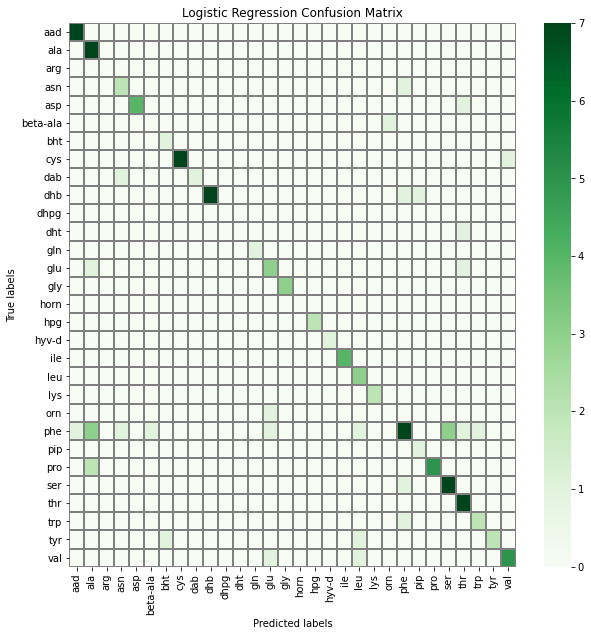

In [180]:
log_grid = {'C': [3], 
                 'penalty': ['l2'],
            'solver' : ['liblinear']
            }

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator, 
                  param_grid=log_grid, 
                  cv=3,
                  scoring='accuracy')

kf = KFold(n_splits=10)
results = cross_val_score(log_model, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results), 
                                                    np.std(results)))
print('===================')


log_model.fit(X_train, y_train)

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:', round(accuracy_score(y_test, log_pred), 3))
print('Logistic Regression macro f1-score:', round(f1_score(y_test, nb_pred, average='macro'), 3))
print(classification_report(y_test, best_log.predict(X_test)))

cm_log = confusion_matrix(y_test, log_pred, labels=labels)

k = 7
cm_log[cm_log > k] = k

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_log, ax=ax, fmt='g', cmap='Greens', 
            xticklabels=labels, yticklabels=labels, 
            linewidth=1, linecolor='grey') 

# labels, title and ticks
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels') 
_ = ax.set_title('Logistic Regression Confusion Matrix') 

# Random Forest

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:569: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:569: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In

Cross Validation accuracy scores: [0.86238532 0.83486239 0.85321101 0.86111111 0.84259259 0.82407407
 0.82407407 0.83333333 0.82407407 0.7962963 ]
Cross Validation accuracy: 0.836 +/- 0.019


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:569: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:569: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In

Best Parameters:
 {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.53, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 51, 'n_jobs': 20, 'warm_start': True}
Random Forest accuracy: 0.863
Random Forest f1-score: 0.708


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         aad       0.90      1.00      0.95         9
         ala       0.97      0.97      0.97       115
         asn       0.75      1.00      0.86         3
         asp       0.57      0.80      0.67         5
    beta-ala       0.50      1.00      0.67         1
         bht       0.50      1.00      0.67         1
         cys       0.89      0.89      0.89         9
         dab       1.00      0.50      0.67         2
         dhb       1.00      0.93      0.97        46
         dht       0.33      1.00      0.50         1
         gln       0.20      1.00      0.33         1
         glu       0.00      0.00      0.00         5
         gly       0.75      1.00      0.86         3
         hpg       1.00      1.00      1.00         2
       hyv-d       1.00      1.00      1.00         1
         ile       1.00      1.00      1.00         4
         leu       0.50      1.00      0.67         3
         lys       0.67    

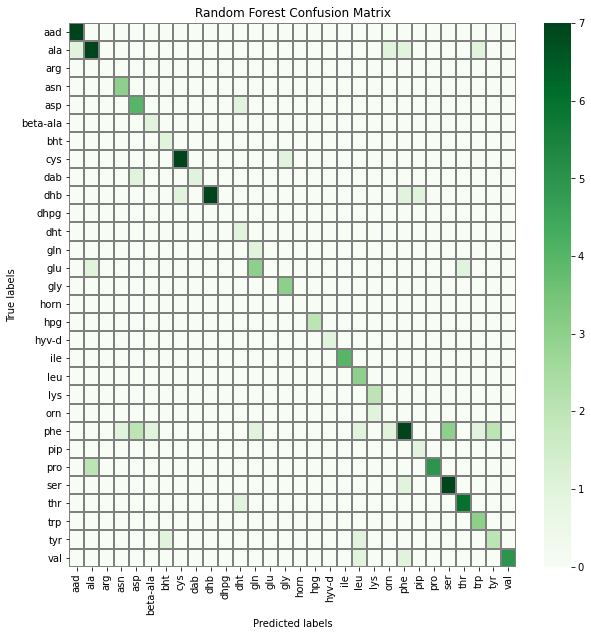

In [183]:
# Hyperparameters search grid 
rf_param_grid = {'bootstrap': [True],
         'n_estimators': [51],
         'max_features': [0.53],
         'min_samples_leaf': [3],
         'min_samples_split': [2],
         'class_weight' : ["balanced"],
                 'criterion' : ['entropy'],
                 'max_depth' : [8],
                 'n_jobs' : [20], 'warm_start' : [True]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='accuracy')


kf = KFold(n_splits=10)
results = cross_val_score(rf_model, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),np.std(results)))
print('===================')

# Fine-tune the hyperparameters
rf_model.fit(X_train, y_train)

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test, rf_pred), 3))
print('Random Forest f1-score:', round(f1_score(y_test, rf_pred, average='macro'), 3))
print(classification_report(y_test, rf_model_best.predict(X_test)))

cm_rf = confusion_matrix(y_test, rf_pred, labels=labels)

k = 7
cm_rf[cm_rf > k] = k

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_rf,  ax=ax, fmt='g', cmap='Greens', 
            xticklabels=labels, yticklabels=labels, 
            linewidth=1, linecolor='grey')

# labels, title and ticks
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels') 
_ = ax.set_title('Random Forest Confusion Matrix') 

# Supporting Vector Machines

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

Cross Validation accuracy scores: [0.86238532 0.85321101 0.89908257 0.91666667 0.83333333 0.89814815
 0.87962963 0.91666667 0.83333333 0.80555556]
Cross Validation accuracy: 0.870 +/- 0.036


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Best Parameters:
 {'C': 0.1, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'kernel': 'poly'}
SVM accuracy: 0.878
SVM macro f1-score: 0.708


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         aad       1.00      1.00      1.00         9
         ala       0.97      0.99      0.98       115
         asn       0.33      0.33      0.33         3
         asp       1.00      0.80      0.89         5
    beta-ala       0.00      0.00      0.00         1
         bht       0.50      1.00      0.67         1
         cys       1.00      0.89      0.94         9
         dab       1.00      0.50      0.67         2
         dhb       1.00      0.91      0.95        46
         dht       0.00      0.00      0.00         1
         gln       1.00      1.00      1.00         1
         glu       0.60      0.60      0.60         5
         gly       1.00      1.00      1.00         3
         hpg       1.00      1.00      1.00         2
       hyv-d       1.00      1.00      1.00         1
         ile       1.00      1.00      1.00         4
         leu       0.75      1.00      0.86         3
         lys       1.00    

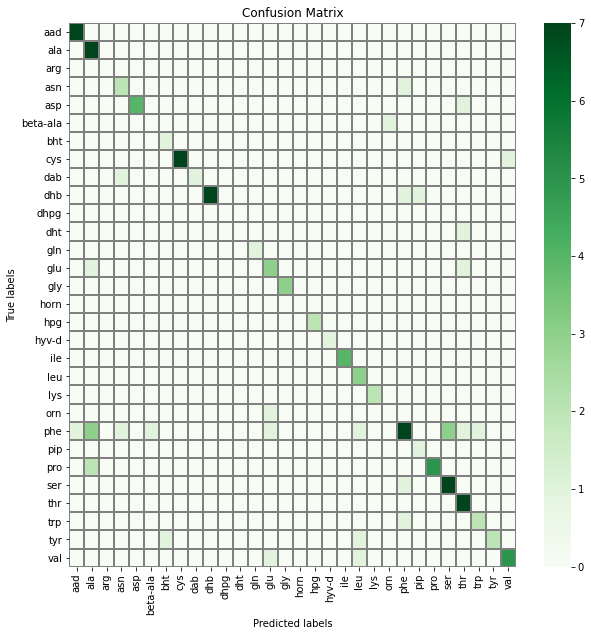

In [184]:
# Parameter grid
svm_param_grid = {'C': [0.1], 
                  'gamma': [0.1], 
                  "kernel": ["poly"], 
                  "decision_function_shape" : ["ovo"]
                  } 

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

kf = KFold(n_splits=10)
results = cross_val_score(svm_grid, X_train, y_train, cv=kf)
print('Cross Validation accuracy scores: %s' % results)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(results),np.std(results)))
print('===================')


# Train the classifier
svm_grid.fit(X_train, y_train)

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test)

print('SVM accuracy:', round(accuracy_score(y_test, svm_pred), 3))
print('SVM macro f1-score:', round(f1_score(y_test, rf_pred, average='macro'), 3))

print(classification_report(y_test, best_svc.predict(X_test)))

cm_svm = confusion_matrix(y_test, svm_pred, labels=labels)

k = 7
cm_svm[cm_svm > k] = k

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_log,  ax=ax, fmt='g', cmap='Greens', 
            xticklabels=labels, yticklabels=labels, 
            linewidth=1, linecolor='grey')

# labels, title and ticks
_ = ax.set_xlabel('Predicted labels')
_ = ax.set_ylabel('True labels') 
_ = ax.set_title('Confusion Matrix') 